# Face Detection Multi-Model OpenVINO Model Server Deployment in OpenShift

We will show you how to deploy OpenVINO Model Server (OVMS) service with multiple models in an OpenShift cluster. We will run a face detection request to the AI inference service which will return age, gender, and emotion recognition as an ouput for each detected face.

Requirements:
- OpenShift cluster with the API access to a project
- installed [OpenVINO Model Server Operator](https://catalog.redhat.com/software/operators/search?q=openvino)
- JupyterLab environment with Python3 deployed in the cluster

If you don't have an OpenShift account, you can sign up for 30 or 60 day [free trial of Red Hat OpenShift](https://www.openshift.com/try).

## Login to OpenShift with API Token

First, let's login to OpenShift cluster using `oc` tool. 

In the Red Hat OpenShift console, click on your username and select `Copy login command`.

![copy-login.png](notebook-files/copy-login.png)

Click on `Display Token` and your API token will appear.

![log-in-with-token.png](notebook-files/log-in-with-token.png)

Copy `Log in with token` command and paste it in the cell below. The command has your `<user-API-token>` and `<cluster-DNS-name>`.

In [1]:
!oc login --token=<user-API-token> --server=https://api.<cluster-DNS-name>:6443

Logged into "https://api.openvino5.3q12.p1.openshiftapps.com:6443" as "nyurguhun" using the token provided.

You have access to the following projects and can switch between them with 'oc project <projectname>':

  * ovms
    rose-jh

Using project "ovms".


Create `ovms` project and go to this project.

In [2]:
!oc new-project ovms
!oc project ovms

Error from server (AlreadyExists): project.project.openshift.io "ovms" already exists
Already on project "ovms" on server "https://api.openvino5.3q12.p1.openshiftapps.com:6443".


## Create MinIO Storage

OpenVINO Model Server exposes DL models over gRPC and REST interface. The models can be stored in cloud storage like AWS S3, Google Storage or Azure Blobs. In OpenShift and Kubernetes, Persistent Storage Claim could be used as well. In this tutorial, we will use MinIO service which is an equivalent of AWS S3.

Let's create a MinIO service.

In [3]:
!oc apply -f minio.yaml

deployment.apps/minio created
service/minio-service created


Next step is to download `mc`, MinIO Client.

In [4]:
!wget https://dl.min.io/client/mc/release/linux-amd64/mc

--2021-05-12 16:33:41--  https://dl.min.io/client/mc/release/linux-amd64/mc
Resolving dl.min.io (dl.min.io)... 178.128.69.202
Connecting to dl.min.io (dl.min.io)|178.128.69.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20819968 (20M) [application/octet-stream]
Saving to: ‘mc’

mc                  100%[===================>]  19.86M  14.3MB/s    in 1.4s    

2021-05-12 16:33:42 (14.3 MB/s) - ‘mc’ saved [20819968/20819968]



Change the access permissions on `mc`, so we can run commands with it.

In [5]:
!chmod 755 mc

Let's make an alias for the MinIO service.

In [6]:
!./mc alias set minio http://minio-service.ovms:9000 minio minio123

Added `minio` successfully.


Create a `minio/models` bucket; it's where we will store our models.

In [7]:
!./mc mb minio/models

Bucket created successfully `minio/models`.


## Create Model Repository

Now, we will upload the models to the MinIO bucket for serving in the OpenVINO Model Server. We will use 3 models:
* [face detection](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/intel/face-detection-retail-0004/description/face-detection-retail-0004.md)
* [age gender recognition](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/intel/age-gender-recognition-retail-0013/description/age-gender-recognition-retail-0013.md)
* [emotion recognition](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/intel/emotions-recognition-retail-0003/description/emotions-recognition-retail-0003.md)

First, we will download the models here.

In [8]:
!curl --create-dirs https://storage.openvinotoolkit.org/repositories/open_model_zoo/2021.3/models_bin/2/age-gender-recognition-retail-0013/FP32/age-gender-recognition-retail-0013.xml -o age-gender/1/age-gender-recognition-retail-0013.xml 
!curl --create-dirs https://storage.openvinotoolkit.org/repositories/open_model_zoo/2021.3/models_bin/2/age-gender-recognition-retail-0013/FP32/age-gender-recognition-retail-0013.bin -o age-gender/1/age-gender-recognition-retail-0013.bin
!curl --create-dirs https://storage.openvinotoolkit.org/repositories/open_model_zoo/2021.3/models_bin/2/face-detection-retail-0004/FP32/face-detection-retail-0004.xml -o face-detection/1/face-detection-retail-0004.xml
!curl --create-dirs https://storage.openvinotoolkit.org/repositories/open_model_zoo/2021.3/models_bin/2/face-detection-retail-0004/FP32/face-detection-retail-0004.bin -o face-detection/1/face-detection-retail-0004.bin
!curl --create-dirs https://storage.openvinotoolkit.org/repositories/open_model_zoo/2021.3/models_bin/2/emotions-recognition-retail-0003/FP32/emotions-recognition-retail-0003.xml -o emotions/1/emotions-recognition-retail-0003.xml
!curl --create-dirs https://storage.openvinotoolkit.org/repositories/open_model_zoo/2021.3/models_bin/2/emotions-recognition-retail-0003/FP32/emotions-recognition-retail-0003.bin -o emotions/1/emotions-recognition-retail-0003.bin

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 30901  100 30901    0     0  54307      0 --:--:-- --:--:-- --:--:-- 54307
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8351k  100 8351k    0     0  11.1M      0 --:--:-- --:--:-- --:--:-- 11.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  101k  100  101k    0     0   711k      0 --:--:-- --:--:-- --:--:--  711k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2297k  100 2297k    0     0  2671k      0 --:--:-- --:--:-- --:--:-- 2668k
  % Total    % Received % Xferd  Average Speed   Tim

Now, copy the models into the MinIO bucket.

In [9]:
!./mc cp --recursive age-gender minio/models/
!./mc cp --recursive face-detection minio/models/
!./mc cp --recursive emotions minio/models/

...-0003.xml:  9.51 MiB / 9.51 MiB ┃▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓┃ 175.37 MiB/s 0s

Let's make sure the models have been successfully copied.

In [10]:
!./mc ls -r minio/models

[2021-05-12 16:33:55 UTC] 8.2MiB age-gender/1/age-gender-recognition-retail-0013.bin
[2021-05-12 16:33:55 UTC]  30KiB age-gender/1/age-gender-recognition-retail-0013.xml
[2021-05-12 16:33:56 UTC] 9.5MiB emotions/1/emotions-recognition-retail-0003.bin
[2021-05-12 16:33:56 UTC]  38KiB emotions/1/emotions-recognition-retail-0003.xml
[2021-05-12 16:33:56 UTC] 2.2MiB face-detection/1/face-detection-retail-0004.bin
[2021-05-12 16:33:56 UTC] 102KiB face-detection/1/face-detection-retail-0004.xml


## Create a Directed Acyclic Graph Pipeline

To implement the multi-model pipeline, we will use a Directed Acyclic Graph, or DAG, scheduler. Here's the workflow.

![graph](notebook-files/faces_analysis_graph.svg)

As you can see from the workflow, DAG is a graph that doesn't have any loops. It consists of processes that are only moving forward.

We will need the `config.json` to define the DAG pipeline. 

In [11]:
!cat config.json

{
  "model_config_list": [
    {"config": {
      "name": "face_detection",
      "base_path": "s3://models/face-detection/",
      "shape": "(1,3,400,600)"}},
    {"config": {
      "name": "age_gender_recognition",
      "base_path": "s3://models/age-gender/",
      "shape": "(1,3,64,64)"}},
    {"config": {
      "name": "emotion_recognition",
      "base_path": "s3://models/emotions/",
      "shape": "(1,3,64,64)"}}
  ],
  "custom_node_library_config_list": [
    {"name": "object_detection_image_extractor",
      "base_path": "/config/libcustom_node.so"}
  ],
  "pipeline_config_list": [
    {
      "name": "find_face_images",
      "inputs": [
        "image"
      ],
      "nodes": [
        {
          "name": "face_detection_node",
          "model_name": "face_detection",
          "type": "DL model",
          "inputs": [
            {"data": {
              "node_name": "request",
              "data_item": "image"}}],
          "outputs": [
            {"data_item": "detecti

## Create a Custom Node

We will use [this custom node](https://github.com/openvinotoolkit/model_server/tree/develop/src/custom_nodes/model_zoo_intel_object_detection) which will analyze the response from the face detection model. Based on the inference results and the input image, the custom node will generate a list of detected boxes. Each image in the output will be resized to the predefined target size to fit the input of the next model in the DAG pipeline. In addition to detected boxes, the results include the coordinates and the detection scores. 

The main functionality of custom node in the OVMS DAG scheduler is that it allows us to create an arbitrary implementation of the data transformation node in the pipeline. It will be attached to the Model Server as a dynamic library. 

Clone the Model Server repo and download OpenCV archive.

In [12]:
!git clone --depth=1 -b develop https://github.com/openvinotoolkit/model_server
!curl -s https://download.01.org/opencv/master/openvinotoolkit/thirdparty/linux/opencv/opencv_4.5.1-044_centos7.txz | tar --use-compress-program=xz -xf -

Cloning into 'model_server'...
remote: Enumerating objects: 588, done.
remote: Counting objects: 100% (588/588), done.
remote: Compressing objects: 100% (508/508), done.
remote: Total 588 (delta 157), reused 272 (delta 60), pack-reused 0
Receiving objects: 100% (588/588), 4.43 MiB | 40.88 MiB/s, done.
Resolving deltas: 100% (157/157), done.


Run commands below to compile `libcustom_node.so`, the custom node library. 

In [13]:
!g++ -c -std=c++17 model_server/src/custom_nodes/model_zoo_intel_object_detection/model_zoo_intel_object_detection.cpp -fpic  -I./opencv/include/ -Wall -Wno-unknown-pragmas -Werror -fno-strict-overflow -fno-delete-null-pointer-checks -fwrapv -fstack-protector
!g++ -shared -o libcustom_node.so model_zoo_intel_object_detection.o -L./opencv/lib/ -I./opencv/include/ -lopencv_core -lopencv_imgproc -lopencv_imgcodecs

Let's check if the custom node library was created.

In [14]:
!ls -l libcustom_node.so

-rwxr-xr-x. 1 1000890000 1000890000 212104 May 12 16:34 libcustom_node.so


## Deploy OpenVINO Model Server with a Multi-Model Pipeline

Let's add the custom node library and `config.json` to a ConfigMap resource. Later, it will be mounted inside the OVMS service.

In [15]:
!oc create configmap ovms-face-detection-pipeline \
                    --from-file=libcustom_node.so=libcustom_node.so \
                    --from-file=config.json=config.json

configmap/ovms-face-detection-pipeline created


Here's the yaml file used to configure the OVMS service. We specified its name to be `ovms-pipeline`.

In [16]:
!cat ovms-face-detection-pipeline.yaml

apiVersion: intel.com/v1alpha1
kind: Ovms
metadata:
  name: ovms-pipeline
  namespace: ovms
spec:
  aws_access_key_id: "minio"
  aws_region: "us-east-1"
  aws_secret_access_key: "minio123"
  s3_compat_api_endpoint: 'http://minio-service:9000'
  config_configmap_name: 'ovms-face-detection-pipeline'
  grpc_port: 8080
  image_name: >-
    registry.connect.redhat.com/intel/openvino-model-server:latest
  log_level: INFO
  plugin_config: '{\"CPU_THROUGHPUT_STREAMS\":\"1\"}'
  replicas: 1
  rest_port: 8081
  service_type: ClusterIP


Let's create the `ovms-pipeline` service.

In [17]:
!oc apply -f ovms-face-detection-pipeline.yaml

ovms.intel.com/ovms-pipeline created


It takes around 15 seconds to create the pod and the service. They should start with `ovms-pipeline`.

In [26]:
!oc get pod
!oc get service

NAME                             READY     STATUS    RESTARTS   AGE
minio-5c57f888dd-vpdcd           1/1       Running   0          65s
ovms-pipeline-66494fbd96-mdjxj   1/1       Running   0          26s
NAME            TYPE        CLUSTER-IP      EXTERNAL-IP   PORT(S)             AGE
minio-service   ClusterIP   172.30.39.13    <none>        9000/TCP            66s
ovms-pipeline   ClusterIP   172.30.91.199   <none>        8080/TCP,8081/TCP   27s


Let's check if the OpenVINO Model Server service is running by making an API request via cURL. Models' `state` should be `AVAILABLE`.

In [27]:
!curl -s http://ovms-pipeline.ovms.svc:8081/v1/config

{
"age_gender_recognition" : 
{
 "model_version_status": [
  {
   "version": "1",
   "state": "AVAILABLE",
   "status": {
    "error_code": "OK",
    "error_message": "OK"
   }
  }
 ]
},
"emotion_recognition" : 
{
 "model_version_status": [
  {
   "version": "1",
   "state": "AVAILABLE",
   "status": {
    "error_code": "OK",
    "error_message": "OK"
   }
  }
 ]
},
"face_detection" : 
{
 "model_version_status": [
  {
   "version": "1",
   "state": "AVAILABLE",
   "status": {
    "error_code": "OK",
    "error_message": "OK"
   }
  }
 ]
},
"find_face_images" : 
{
 "model_version_status": [
  {
   "version": "1",
   "state": "AVAILABLE",
   "status": {
    "error_code": "OK",
    "error_message": "OK"
   }
  }
 ]
}
}

## Run an Inference Request

The pipeline execution is represented as the `find_face_images` model. The client runs an inference request exactly the same way as it would run with a single model.

Let's import Python packages needed for inference request.

In [28]:
import grpc
import cv2
import os
import numpy as np
from tensorflow import make_tensor_proto, make_ndarray
import argparse
from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc
from IPython.display import Image, display

We will run face detection on this image.

![people](people.jpg)


Prepare the image for sending it in the gRPC request to the `ovms-pipeline` service.

In [29]:
img = cv2.imread('people.jpg').astype(np.float32)  # BGR color format, shape HWC
resolution = (400, 600)
img = cv2.resize(img, (resolution[1], resolution[0]))
img = img.transpose(2,0,1).reshape(1,3,resolution[0],resolution[1])

Next, let's establish connection with the `ovms-pipeline` service.

In [30]:
address = "ovms-pipeline.ovms.svc:8080"
MAX_MESSAGE_LENGTH = 1024 * 1024 * 8  # incresed default max size of the message
channel = grpc.insecure_channel(address,
    options=[
        ('grpc.max_send_message_length', MAX_MESSAGE_LENGTH),
        ('grpc.max_receive_message_length', MAX_MESSAGE_LENGTH),
    ])

stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)
request = predict_pb2.PredictRequest()
request.model_spec.name = "find_face_images"

Send the request and prediction will be executed. Note that the exception is handled when the pipeline doesn't detect any face in the image. 

In [31]:
request.inputs['image'].CopyFrom(make_tensor_proto(img, shape=img.shape))
try:
    response = stub.Predict(request, 10.0)
except grpc.RpcError as err:
    if err.code() == grpc.StatusCode.ABORTED:
        print('No face has been found in the image')
        exit(1)
    else:
        raise err


We will receive results as `ages`, `genders`, `emotions`, and `face_coordinates` in `response` object. `face_images` output returns cropped faces retrieved from the original image.

Define functions to process the output.

In [32]:
images = []
def save_face_images_as_jpgs(output_nd, name, location):
    for i in range(output_nd.shape[0]):
        out = output_nd[i][0]
        out = out.transpose(1,2,0)
        output_file_name = name + '_' + str(i) + '.jpg'
        cv2.imwrite(os.path.join(location, output_file_name), out)
        images.append(output_file_name)
        
def update_people_ages(output_nd, people):
    for i in range(output_nd.shape[0]):
        age = int(output_nd[i,0,0,0,0] * 100)
        if len(people) < i + 1:
            people.append({'age': age})
        else:
            people[i].update({'age': age})
    return people

def update_people_genders(output_nd, people):
    for i in range(output_nd.shape[0]):
        gender = 'male' if output_nd[i,0,0,0,0] < output_nd[i,0,1,0,0] else 'female'
        if len(people) < i + 1:
            people.append({'gender': gender})
        else:
            people[i].update({'gender': gender})
    return people

def update_people_emotions(output_nd, people):
    emotion_names = {
        0: 'neutral',
        1: 'happy',
        2: 'sad',
        3: 'surprised',
        4: 'angry'
    }
    for i in range(output_nd.shape[0]):
        emotion_id = np.argmax(output_nd[i,0,:,0,0])
        emotion = emotion_names[emotion_id]
        if len(people) < i + 1:
            people.append({'emotion': emotion})
        else:
            people[i].update({'emotion': emotion})
    return people

def update_people_coordinate(output_nd, people):
    for i in range(output_nd.shape[0]):
        if len(people) < i + 1:
            people.append({'coordinate': output_nd[i,0,:]})
        else:
            people[i].update({'coordinate': output_nd[i,0,:]})
    return people

Let's process the output.

In [33]:
people = []

for name in response.outputs:
    print(f"Output: name[{name}]")
    tensor_proto = response.outputs[name]
    output_nd = make_ndarray(tensor_proto)
    print(f"    numpy => shape[{output_nd.shape}] data[{output_nd.dtype}]")

    if name == 'face_images':
        save_face_images_as_jpgs(output_nd, name, ".")
    if name == 'ages':
        people = update_people_ages(output_nd, people)
    if name == 'genders':
        people = update_people_genders(output_nd, people)
    if name == 'emotions':
        people = update_people_emotions(output_nd, people)
    if name == 'face_coordinates':
        people = update_people_coordinate(output_nd, people)

Output: name[emotions]
    numpy => shape[(6, 1, 5, 1, 1)] data[float32]
Output: name[ages]
    numpy => shape[(6, 1, 1, 1, 1)] data[float32]
Output: name[genders]
    numpy => shape[(6, 1, 2, 1, 1)] data[float32]
Output: name[face_images]
    numpy => shape[(6, 1, 3, 64, 64)] data[float32]
Output: name[confidence_levels]
    numpy => shape[(6, 1, 1)] data[float32]
Output: name[face_coordinates]
    numpy => shape[(6, 1, 4)] data[float32]


Now we can view the results.


Found 6 faces:



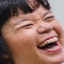


Estimated Age: 28
Estimated Gender: male
Estimated Emotion: happy
Original Image Coordinates:[0.3782609  0.35938    0.44495052 0.5501346 ]



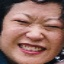


Estimated Age: 29
Estimated Gender: female
Estimated Emotion: angry
Original Image Coordinates:[0.7024455  0.3754582  0.77637887 0.5739976 ]



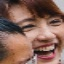


Estimated Age: 24
Estimated Gender: male
Estimated Emotion: happy
Original Image Coordinates:[0.16671757 0.31987876 0.23432626 0.50335705]



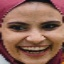


Estimated Age: 22
Estimated Gender: female
Estimated Emotion: happy
Original Image Coordinates:[0.7956609  0.386524   0.85938865 0.5990172 ]



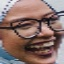


Estimated Age: 32
Estimated Gender: male
Estimated Emotion: happy
Original Image Coordinates:[0.5632465  0.37932324 0.61377335 0.57810456]



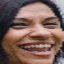


Estimated Age: 21
Estimated Gender: female
Estimated Emotion: happy
Original Image Coordinates:[0.9035787  0.31419483 0.9603891  0.52992076]



In [34]:
print('\nFound', len(people), 'faces:\n')
for num, person in enumerate(people):
    display(Image(images[num]))
    print(f"""
Estimated Age: {person['age']}
Estimated Gender: {person['gender']}
Estimated Emotion: {person['emotion']}
Original Image Coordinates:{person['coordinate']}\n""")

## Cleanup

Let's free up resources.

In [35]:
!oc delete ovms ovms-pipeline
!oc delete deploy minio
!oc delete service minio-service
!oc delete configmap ovms-face-detection-pipeline

ovms.intel.com "ovms-pipeline" deleted
deployment.apps "minio" deleted
service "minio-service" deleted
configmap "ovms-face-detection-pipeline" deleted


In [36]:
!rm -rf age-gender
!rm -rf emotions
!rm -rf face-detection
!rm -rf python
!rm -rf opencv
!rm -rf model_server
!rm mc
!rm face_images_*

E0512 16:36:11.541914476   11783 backup_poller.cc:133]       Run client channel backup poller: {"created":"@1620837371.541887269","description":"pollset_work","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":321,"referenced_errors":[{"created":"@1620837371.541886155","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":948,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}
E0512 16:36:12.541738498   11799 ev_epollex_linux.cc:1365]   pollset_set_add_fd: {"created":"@1620837372.541698898","description":"pollset_set_add_fd","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":321,"referenced_errors":[{"created":"@1620837372.541698058","description":"pollable_add_fd","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":321,"referenced_errors":[{"created":"@1620837372.541696844","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":631,"os_error":"Bad fil

## Next Steps

In this notebook, you have learned how to deploy an OVMS service with multiple models in an OpenShift cluster. Next, you can explore other OVMS notebooks:

- [Deploy Image Classification with OpenVINO Model Server in OpenShift](../401-model-serving-openshift-resnet/ovms-openshift-resnet.ipynb)
- [Send gRPC and API Calls via Python Scripts to OpenVINO Model Server in OpenShift](../402-model-serving-openshift-python-scripts/ovms-openshift-python-scripts.ipynb)
